In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from pylab import mpl

In [2]:
# pip install https://github.com/fmzquant/backtest_python/archive/master.zip

In [3]:
'''backtest
start: 2020-05-11 00:00:00
end: 2020-08-08 00:00:00
period: 1d
exchanges: [{"eid":"OKEX","currency":"LTC_BTC","balance":3,"stocks":0}]
'''

#上面注释是回测设置
from fmz import * # 导入所有FMZ函数
task = VCtx(__doc__) # 初始化

In [4]:
kline = get_bars('futures_bitmex.bxbt', '1d', start='2018-01-01', end='2020-08-08')
new_index=pd.date_range("2018-01-01", "2020-08-07", freq="D")
kline.index=new_index
close_data = kline.close

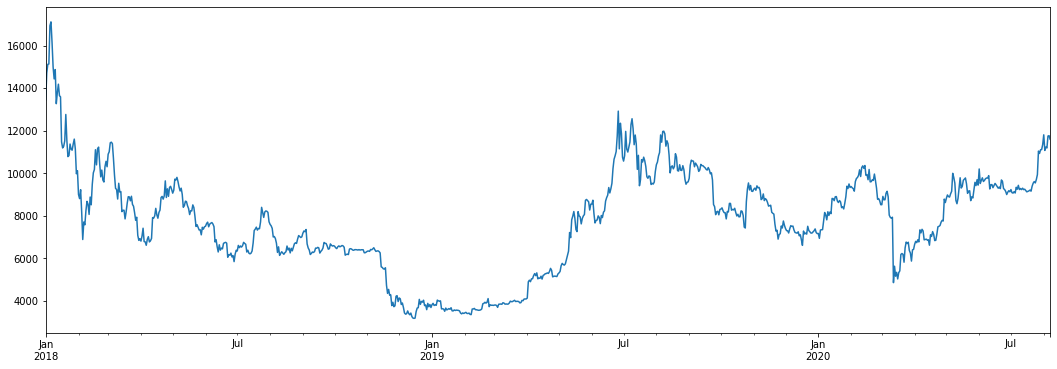

In [7]:
close_data.plot(figsize = (18, 6))

计算 Hurst Exponent。若其介于0-0.5，序列符合均值回归；若等于0.5，序列为随机游走，若介于0.5-1，序列为趋势跟踪。

In [8]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(5,100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:].tolist(), ts[:-lag].tolist()))) for lag in lags]
   
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

In [9]:
hurst(close_data)
# Hurst 介于0-0.5，采用均值回归。
#从另一个角度看，上次的分析已证明收盘价为平稳序列，符合均值回归的前提。(ADF检验的p值为0.033，小于0.05）

0.41448089191279536

In [10]:
# 计算半衰期，作为移动平均的窗口
from sklearn import linear_model
df_close = close_data.to_frame()
df_lag = df_close.shift(1)
df_delta = df_close - df_lag
lin_reg_model = linear_model.LinearRegression()
df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
df_lag = df_lag.values.reshape(len(df_lag),1)
lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
half_life = -np.log(2) / lin_reg_model.coef_.item()
print ('Half life:       %s' % half_life)           #  260.65118856658813


Half life:       54.1684651937249


In [11]:
lookback_window = 49

signals = pd.DataFrame(index=close_data.index)
signals['signal'] = 0.0
# 计算移动平均和标准差
signals['mov_avg'] = close_data.rolling(window=lookback_window, min_periods=1, center=False).mean()
signals['mov_std'] = close_data.rolling(window=lookback_window, min_periods=1, center=False).std()
# 计算 z-score
signals['mov_z_score'] = (close_data - signals['mov_avg']) / signals['mov_std']

# 发出信号
signals['signal'][lookback_window:] = np.where(signals['mov_z_score'][lookback_window:] 
                                            < -2.0 , 1.0, 0.0)  
signals['signal'][lookback_window:].loc[signals['mov_z_score'] > -1.0] = np.where(signals['mov_z_score'][lookback_window:].loc[signals['mov_z_score'] > -1.0]
                                            > 2.0 , -1.0, 0.0)  

# 交易
signals['positions'] = signals['signal']
signals['positions'].loc[signals['signal'].diff() == 0] = 0

change = signals['positions'].loc[signals['positions'] != 0]
change = change.loc[change.diff() == 0]
signals['positions'][change.index] = 0                                         

signals['adjusted_signal'] = np.where(signals['positions'].cumsum() == 1 , 1.0, 0.0) 

# Print `signals`
pd.set_option('display.max_rows', None)
print(signals)


            signal       mov_avg      mov_std  mov_z_score  positions  \
2018-01-01     0.0  13461.700000          NaN          NaN        0.0   
2018-01-02     0.0  14095.950000   896.964952     0.707107        0.0   
2018-01-03     0.0  14439.600000   869.804018     0.790178        0.0   
2018-01-04     0.0  14615.775000   792.794557     0.666661        0.0   
2018-01-05     0.0  15081.420000  1247.204369     1.493404        0.0   
2018-01-06     0.0  15421.900000  1392.829771     1.222260        0.0   
2018-01-07     0.0  15525.785714  1300.842548     0.479162        0.0   
2018-01-08     0.0  15459.675000  1218.775914    -0.379705        0.0   
2018-01-09     0.0  15346.622222  1189.439474    -0.760377        0.0   
2018-01-10     0.0  15300.110000  1131.018956    -0.370118        0.0   
2018-01-11     0.0  15116.100000  1234.398628    -1.490685        0.0   
2018-01-12     0.0  15006.483333  1236.692330    -0.975007        0.0   
2018-01-13     0.0  14943.900000  1205.352238    -0

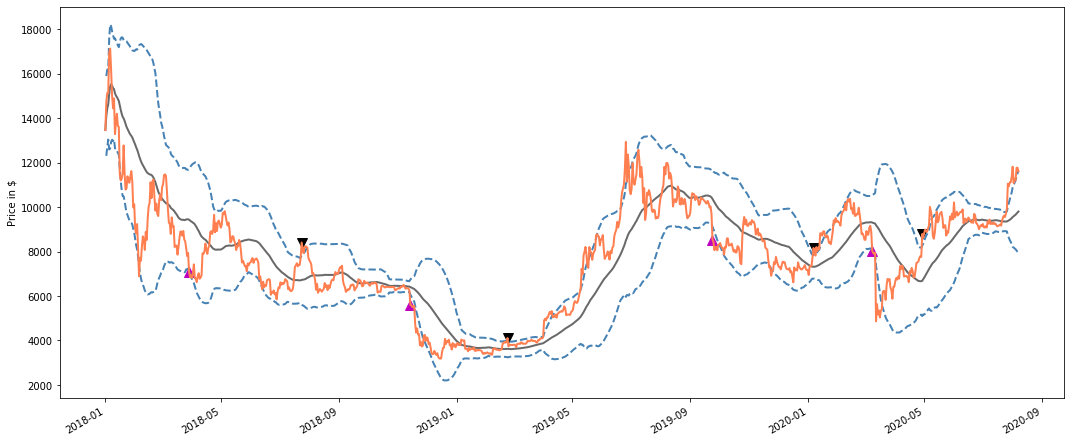

In [13]:
# 绘制移动平均和信号图
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(111,  ylabel='Price in $')

upper_bound = signals['mov_avg'] + 2 * signals['mov_std']
lower_bound = signals['mov_avg'] - 2 * signals['mov_std']

# 买入信号
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         close_data[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# 卖出信号
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         close_data[signals.positions == -1.0],
         'v', markersize=10, color='k')
# 上下界
upper_bound.plot(ax=ax1, color='steelblue', linestyle='--', lw=2.)
lower_bound.plot(ax=ax1, color='steelblue', linestyle='--', lw=2.)

signals['mov_avg'].plot(ax=ax1, color='dimgray', lw=2.)

close_data.plot(ax=ax1, color='coral', lw=2.)


# Show the plot
plt.show()



下面是均值回归策略回测

In [15]:
# 初始资本
initial_capital= float(100000.0)
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# 买入15股，该数值可调整 
positions['bit'] = 15*signals['adjusted_signal']
portfolio = positions.multiply(close_data, axis=0)
pos_diff = positions.diff()
# 持有
portfolio['holdings'] = (positions.multiply(close_data, axis=0)).sum(axis=1)
#现金
portfolio['cash'] = initial_capital - (pos_diff.multiply(close_data, axis=0)).sum(axis=1).cumsum()   

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

print(portfolio)

                  bit   holdings       cash      total   returns
2018-01-01       0.00       0.00  100000.00  100000.00       NaN
2018-01-02       0.00       0.00  100000.00  100000.00  0.000000
2018-01-03       0.00       0.00  100000.00  100000.00  0.000000
2018-01-04       0.00       0.00  100000.00  100000.00  0.000000
2018-01-05       0.00       0.00  100000.00  100000.00  0.000000
2018-01-06       0.00       0.00  100000.00  100000.00  0.000000
2018-01-07       0.00       0.00  100000.00  100000.00  0.000000
2018-01-08       0.00       0.00  100000.00  100000.00  0.000000
2018-01-09       0.00       0.00  100000.00  100000.00  0.000000
2018-01-10       0.00       0.00  100000.00  100000.00  0.000000
2018-01-11       0.00       0.00  100000.00  100000.00  0.000000
2018-01-12       0.00       0.00  100000.00  100000.00  0.000000
2018-01-13       0.00       0.00  100000.00  100000.00  0.000000
2018-01-14       0.00       0.00  100000.00  100000.00  0.000000
2018-01-15       0.00    

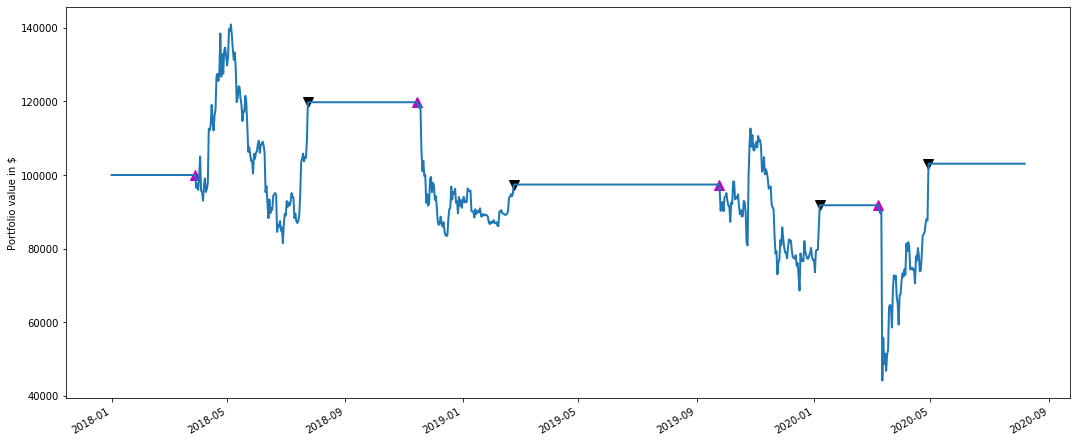

In [16]:
# 投资组合
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')


portfolio['total'].plot(ax=ax1, lw=2.)

plt.show()

In [18]:
# Brad's revision:
# 策略评估
return_1 = (portfolio['total'][-1] - portfolio['total'][0]) / portfolio['total'][0]
std_1 = np.std((portfolio['total'] - portfolio['total'][0]) / portfolio['total'][0])
# 参考国债回报率
risk_free = 0.1
sharp_1 = (return_1 - risk_free) / std_1
sharp_1

-0.5221219963823827

夏普比率小于0，说明收益低于无风险利率。从上图和三年来收益来看，均值回归表现一般。

在最初的分析中可得出动量策略在这里并不适用，但依然在此给出示例。

In [19]:
# 确定长、短窗口，可通过回测调整数值
short_window = 30
long_window = 100

signals_1 = pd.DataFrame(index=close_data.index)
signals_1['signal'] = 0.0

# 计算移动平均
signals_1['short_mavg'] = close_data.rolling(window=short_window, min_periods=1, center=False).mean()

signals_1['long_mavg'] = close_data.rolling(window=long_window, min_periods=1, center=False).mean()

# 产生信号
signals_1['signal'][short_window:] = np.where(signals_1['short_mavg'][short_window:] 
                                            > signals_1['long_mavg'][short_window:], 1.0, 0.0)   

#交易
signals_1['positions'] = signals_1['signal'].diff()

pd.set_option('display.max_rows', None)
print(signals_1)


            signal    short_mavg     long_mavg  positions
2018-01-01     0.0  13461.700000  13461.700000        NaN
2018-01-02     0.0  14095.950000  14095.950000        0.0
2018-01-03     0.0  14439.600000  14439.600000        0.0
2018-01-04     0.0  14615.775000  14615.775000        0.0
2018-01-05     0.0  15081.420000  15081.420000        0.0
2018-01-06     0.0  15421.900000  15421.900000        0.0
2018-01-07     0.0  15525.785714  15525.785714        0.0
2018-01-08     0.0  15459.675000  15459.675000        0.0
2018-01-09     0.0  15346.622222  15346.622222        0.0
2018-01-10     0.0  15300.110000  15300.110000        0.0
2018-01-11     0.0  15116.100000  15116.100000        0.0
2018-01-12     0.0  15006.483333  15006.483333        0.0
2018-01-13     0.0  14943.900000  14943.900000        0.0
2018-01-14     0.0  14851.628571  14851.628571        0.0
2018-01-15     0.0  14768.086667  14768.086667        0.0
2018-01-16     0.0  14562.468750  14562.468750        0.0
2018-01-17    

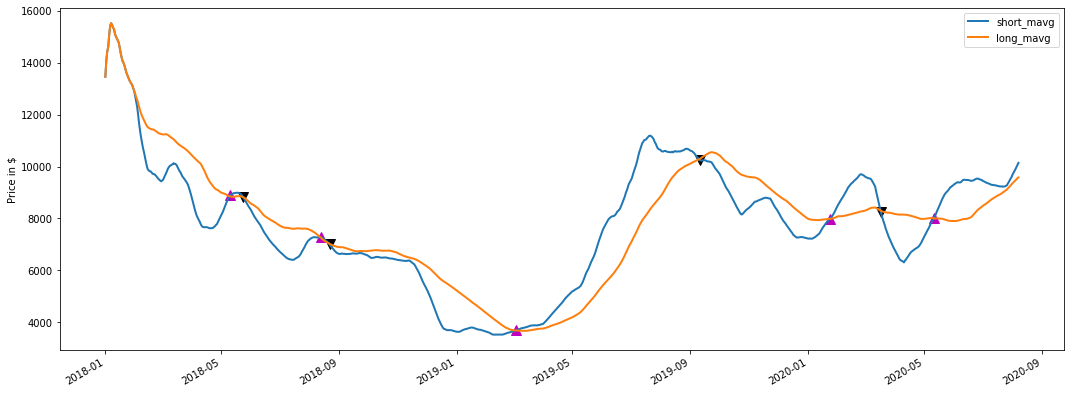

In [21]:
# 绘制移动平均和信号图
fig = plt.figure(figsize = (18,7))

ax1 = fig.add_subplot(111,  ylabel='Price in $')

# 买入信号
ax1.plot(signals_1.loc[signals_1.positions == 1.0].index, 
         signals_1.short_mavg[signals_1.positions == 1.0],
         '^', markersize=10, color='m')
         
# 卖出信号
ax1.plot(signals_1.loc[signals_1.positions == -1.0].index, 
         signals_1.short_mavg[signals_1.positions == -1.0],
         'v', markersize=10, color='k')

signals_1[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
        
# Show the plot
plt.show()

下面是动量策略回测

In [22]:
# 初始资本
initial_capital= float(100000.0)
positions = pd.DataFrame(index=signals_1.index).fillna(0.0)

# 买入15股，该数值可调整
positions['bit'] = 15*signals_1['signal']
portfolio = positions.multiply(close_data, axis=0)
pos_diff = positions.diff()
# 持有
portfolio['holdings'] = (positions.multiply(close_data, axis=0)).sum(axis=1)
#现金
portfolio['cash'] = initial_capital - (pos_diff.multiply(close_data, axis=0)).sum(axis=1).cumsum()   

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

print(portfolio)

                  bit   holdings       cash      total   returns
2018-01-01       0.00       0.00  100000.00  100000.00       NaN
2018-01-02       0.00       0.00  100000.00  100000.00  0.000000
2018-01-03       0.00       0.00  100000.00  100000.00  0.000000
2018-01-04       0.00       0.00  100000.00  100000.00  0.000000
2018-01-05       0.00       0.00  100000.00  100000.00  0.000000
2018-01-06       0.00       0.00  100000.00  100000.00  0.000000
2018-01-07       0.00       0.00  100000.00  100000.00  0.000000
2018-01-08       0.00       0.00  100000.00  100000.00  0.000000
2018-01-09       0.00       0.00  100000.00  100000.00  0.000000
2018-01-10       0.00       0.00  100000.00  100000.00  0.000000
2018-01-11       0.00       0.00  100000.00  100000.00  0.000000
2018-01-12       0.00       0.00  100000.00  100000.00  0.000000
2018-01-13       0.00       0.00  100000.00  100000.00  0.000000
2018-01-14       0.00       0.00  100000.00  100000.00  0.000000
2018-01-15       0.00    

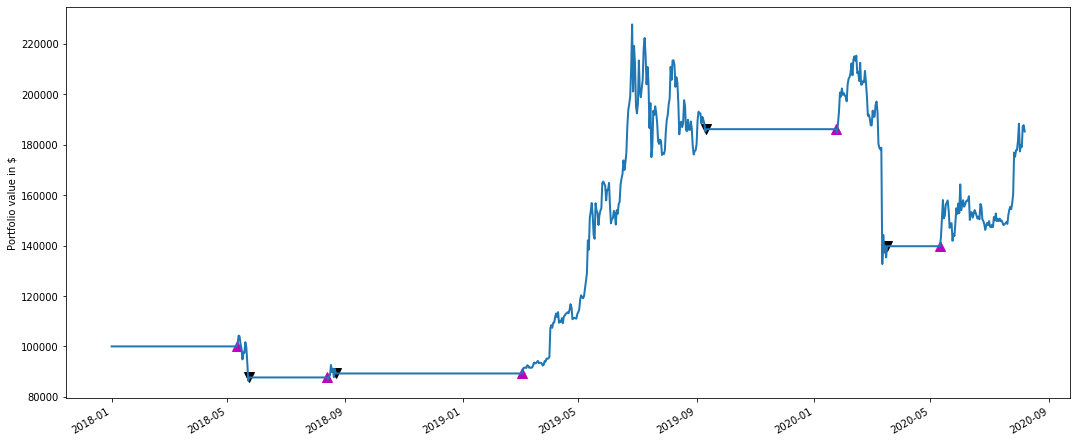

In [23]:
# 投资组合
fig = plt.figure(figsize = (18,8))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
ax1.plot(portfolio.loc[signals_1.positions == 1.0].index, 
         portfolio.total[signals_1.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals_1.positions == -1.0].index, 
         portfolio.total[signals_1.positions == -1.0],
         'v', markersize=10, color='k')


portfolio['total'].plot(ax=ax1, lw=2.)

plt.show()

In [24]:
# 策略评估
return_2 = (portfolio['total'][-1] - portfolio['total'][0]) / portfolio['total'][0]
std_2 = np.std((portfolio['total'] - portfolio['total'][0]) / portfolio['total'][0])
risk_free = 0.1
sharp_2 = (return_2 - risk_free) / std_2
sharp_2

1.741645842017392

夏普比率大于1，组合报酬率高过波动风险。
尽管开始的分析认为均值回归相比动量策略更合适，但在回测中动量策略明显优于均值回归。原因可能与较强的自相关性有关。说明策略的选择不能仅仅依靠平稳性分析等，还需要实际操作的比较。

Reference:
- https://www.treasury.gov/

- https://medium.com/datacamp/python-for-finance-algorithmic-trading-60fdfb9bb20d

- https://blog.quantinsti.com/mean-reversion-time-series/

- https://medium.com/the-ocean-trade/the-ocean-x-algo-trading-lesson-1-time-series-analysis-fa3b76f1d4a3

- https://letianzj.github.io/mean-reversion.html

- https://robotwealth.com/demystifying-the-hurst-exponent-part-2/

- https://medium.com/auquan/mean-reversion-simple-trading-strategies-part-1-a18a87c1196a